In [1]:
!gcloud config set project etsy-bigquery-adhoc-prod


If you have a compatible Python interpreter installed, you can use it by setting
the CLOUDSDK_PYTHON environment variable to point to it.

Updated property [core/project].


In [2]:
%load_ext google.cloud.bigquery

In [3]:
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

# Run the following in Bigquery
```
create table `etsy-sr-etl-prod.yzhang.visual_diversity_vsv2_embedding` as (
  with train_data as (
    select distinct
        requestUUID, position, visitId,
        ctx.docInfo.queryInfo.query as query_str,
        ctx.docInfo.queryInfo.queryLevelMetrics.bin as query_bin,
        candidateInfo.docInfo.listingInfo.listingId as listing_id,
    from `etsy-ml-systems-prod.attributed_instance.query_pipeline_web_organic_2023_09_08`,
        unnest(contextualInfo) as ctx
    where ctx.docInfo.queryInfo.query is not null
    and candidateInfo.docInfo.listingInfo.listingId is not null
  ),
  fb_data as (
    select key as listing_id, VSV2Embeddings_vsv2Embedding512.list as embedding
    from `etsy-ml-systems-prod.feature_bank_v2.listing_feature_bank_2023-09-08`
    where key in (
      select distinct listing_id from train_data
    )
  ),
  results as (
    select train_data.*, fb_data.embedding
    from train_data
    join fb_data
    on train_data.listing_id = fb_data.listing_id
  )
  select * from results  
)
```

Run dataflow job to get cosine sim

In [7]:
%%bigquery df
with query_gms as (
  select query, visit_id, sum(attributed_gms) as gms
  from `etsy-data-warehouse-prod.search.query_sessions_new`
  where _date = date('2023-09-08')
  group by query, visit_id
)
select vsv2.*, gms
from `etsy-sr-etl-prod.yzhang.explore_visual_diversity_vsv2` vsv2
left join query_gms
on vsv2.query_str = query_gms.query
and vsv2.visitId = query_gms.visit_id
limit 900000

Downloading: 100%|██████████████████| 900000/900000 [04:47<00:00, 3133.03rows/s]


In [8]:
df.head(n=3)

,requestUUID,visitId,query_str,query_bin,listing_ids,cosine_sim,gms
0,d12a35a5-6a66-484d-96b9-d4c2e6b04100,pL8RH3l4fl97rtrxjiI2lYgR5CIC.1694140207674.2,بشت,None,"[1524322224, 1537635034, 1493458710, 152432317...","[1.0, 0.2992900656546054, 0.05547862926272468,...",NaN
1,67591e7c-b8e6-46ce-82e8-133c984e20dc,dCoMPs67o_UzdwP9q79Er4Wk7MmS.1694208472573.1,graduate t shirt disney,None,"[1482866657, 1454781273, 1446214328, 148133988...","[1.0000000000000004, 0.6175431332050376, 0.617...",NaN
2,f3533b74-bb85-4e0f-8395-32420e9ab08a,VjKDE_a6Py8qMxQldgYwWcUj93C8.1694206979054.1,his and hers earring,None,"[1365253424, 1215856952, 1038900457, 132478197...","[1.0000000000000002, 0.36514584667406347, 0.45...",NaN


In [9]:
df.shape

(900000, 7)

In [10]:
df[~df.gms.isna()].shape

(488737, 7)

# Distribution of similarity scores

In [11]:
## Overall - sample 10000 requests
df_sub = df.sample(n=10000, replace=False).reset_index(inplace=False)

In [12]:
all_scores = []
for i in tqdm(range(10000)):
    d = int(np.sqrt(len(df_sub.cosine_sim[i])))
    sim_mat = np.reshape(np.copy(df_sub.cosine_sim[i]), (d, d))
    np.fill_diagonal(sim_mat, np.nan)
    sim_scores = sim_mat.flatten()
    all_scores.append(sim_scores)

100%|███████████████████████████████████| 10000/10000 [00:02<00:00, 4534.01it/s]


<Axes: ylabel='Count'>

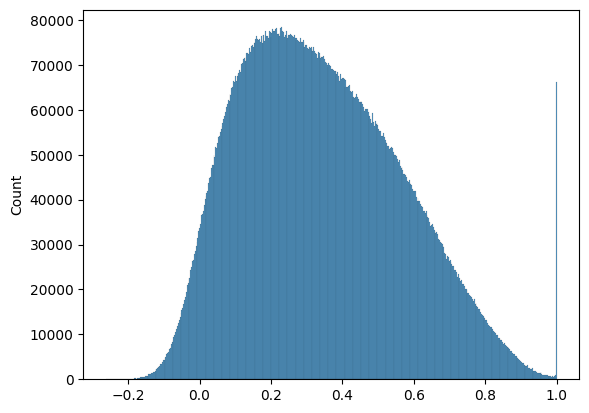

In [13]:
all_scores_flatten = np.concatenate(all_scores)
sns.histplot(all_scores_flatten)

In [14]:
## By query bin
df.query_bin.unique()

array([None, 'head', 'tail', 'top.1', 'torso', 'top.01'], dtype=object)

In [15]:
df_head = df[df.query_bin == "head"]; print(df_head.shape)
df_tail = df[df.query_bin == "tail"]; print(df_tail.shape)
df_torso = df[df.query_bin == "torso"]; print(df_torso.shape)
df_top1 = df[df.query_bin == "top.1"]; print(df_top1.shape)
df_top01 = df[df.query_bin == "top.01"]; print(df_top01.shape)

(264365, 7)
(56111, 7)
(74118, 7)
(162676, 7)
(190694, 7)


In [16]:
def get_sim_scores(data_df):
    all_scores = []
    for i in tqdm(range(data_df.shape[0])):
        d = int(np.sqrt(len(data_df.cosine_sim[i])))
        sim_mat = np.reshape(np.copy(data_df.cosine_sim[i]), (d, d))
        np.fill_diagonal(sim_mat, np.nan)
        sim_scores = sim_mat.flatten()
        all_scores.append(sim_scores[~np.isnan(sim_scores)])
    return np.concatenate(all_scores)

In [17]:
df_head_sub = df_head.sample(n=10000, replace=False).reset_index(inplace=False)
head_scores = get_sim_scores(df_head_sub)

df_tail_sub = df_tail.sample(n=10000, replace=False).reset_index(inplace=False)
tail_scores = get_sim_scores(df_tail_sub)

df_torso_sub = df_torso.sample(n=10000, replace=False).reset_index(inplace=False)
torso_scores = get_sim_scores(df_torso_sub)

df_top1_sub = df_top1.sample(n=10000, replace=False).reset_index(inplace=False)
top1_scores = get_sim_scores(df_top1_sub)

df_top01_sub = df_top01.sample(n=10000, replace=False).reset_index(inplace=False)
top01_scores = get_sim_scores(df_top01_sub)

100%|███████████████████████████████████| 10000/10000 [00:02<00:00, 4747.93it/s]


In [18]:
print(np.min(top01_scores)); print(np.max(top01_scores))

-0.2990471377509041
1.0000000000000013


In [19]:
print(np.min(head_scores)); print(np.max(head_scores))

-0.26694806669701954
1.0000000000000013


In [20]:
print(np.min(tail_scores)); print(np.max(tail_scores))

-0.26090362842985976
1.000000000000001


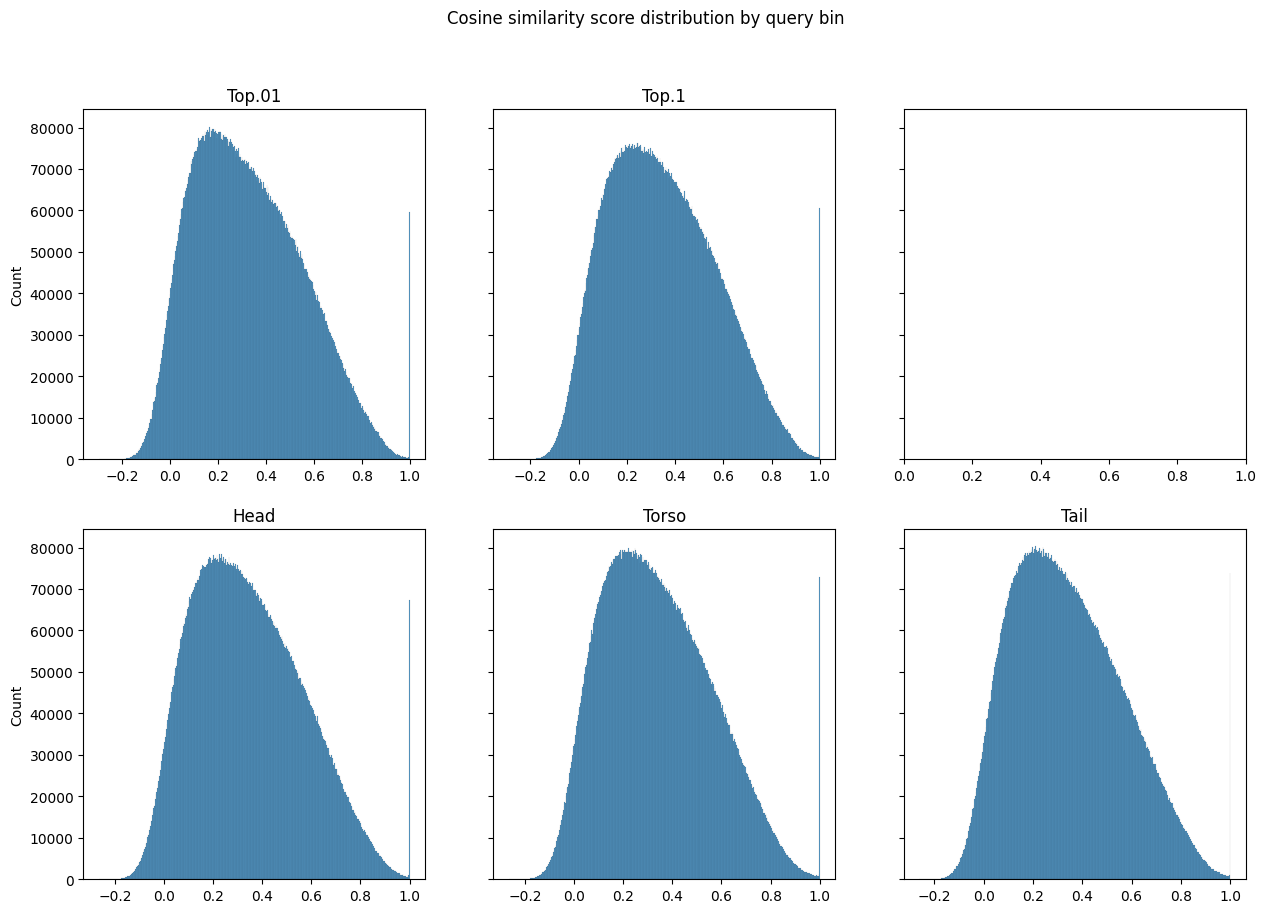

In [21]:
fig, axes = plt.subplots(2, 3, figsize=(15, 10), sharey=True)
fig.suptitle('Cosine similarity score distribution by query bin')

sns.histplot(ax=axes[0, 0], data=top01_scores)
axes[0, 0].set_title("Top.01")

sns.histplot(ax=axes[0, 1], data=top1_scores)
axes[0, 1].set_title("Top.1")

sns.histplot(ax=axes[1, 0], data=head_scores)
axes[1, 0].set_title("Head")

sns.histplot(ax=axes[1, 1], data=torso_scores)
axes[1, 1].set_title("Torso")

sns.histplot(ax=axes[1, 2], data=tail_scores)
axes[1, 2].set_title("Tail")

plt.show()

# Threshold vs GMS

In [23]:
df_gms = df[~df.gms.isna()]
df_gms = df_gms[df_gms.gms > 0.]

In [24]:
df.gms.dropna().sum()

57850142.0

In [25]:
df_gms.gms.sum()

57850142.0

In [26]:
df_gms.shape

(26173, 7)

In [27]:
df_gms.reset_index(inplace=True)

In [28]:
thresholds = [0.0001, 0.001, 0.01, 0.05, 0.1, 0.2]
threshold_gms = {str(th): 0.0 for th in thresholds}

for i in tqdm(range(df_gms.shape[0])):
    d = int(np.sqrt(len(df_gms.cosine_sim[i])))
    sim_mat = np.reshape(np.copy(df_gms.cosine_sim[i]), (d, d))
    np.fill_diagonal(sim_mat, np.nan)
    sim_scores = sim_mat.flatten()
    offdiag_sim_scores = sim_scores[~np.isnan(sim_scores)]
    for k, v in threshold_gms.items():
        if np.any(offdiag_sim_scores > (1. - float(k))):
            threshold_gms[k] = v + df_gms.gms[i]

100%|███████████████████████████████████| 26173/26173 [00:10<00:00, 2612.88it/s]


In [29]:
threshold_gms

{'0.0001': 14433725.0,
 '0.001': 16017607.0,
 '0.01': 19458232.0,
 '0.05': 28408228.0,
 '0.1': 38808329.0,
 '0.2': 52165413.0}

# How discriminative are the scores

Sample 20 pairs of listings with sim score > thresholds

In [30]:
df_sampled = df.sample(n=10000, replace=False).reset_index(inplace=False)

In [31]:
thresholds = [0.0001, 0.001, 0.01, 0.05, 0.1, 0.2]
threshold_listings = {str(th): set() for th in thresholds}

for i in tqdm(range(df_sampled.shape[0])):
    d = int(np.sqrt(len(df_sampled.cosine_sim[i])))
    sim_mat = np.reshape(np.copy(df_sampled.cosine_sim[i]), (d, d))
    cand_listings = list(df_sampled.listing_ids[i])
    np.fill_diagonal(sim_mat, np.nan)
    
    for j in range(d):
        for k in range(j+1, d):
            for key, val in threshold_gms.items():
                if (sim_mat[j, k] > (1.0 - float(key))) and (cand_listings[j] != cand_listings[k]):
                    threshold_listings[key].add((cand_listings[j], cand_listings[k]))

100%|████████████████████████████████████| 10000/10000 [00:33<00:00, 298.60it/s]


In [32]:
[len(v) for v in threshold_listings.values()]

[3159, 3628, 4824, 11341, 31762, 168351]

In [37]:
for key, val in threshold_listings.items():
    print(key)
    val = list(val)
    sampled_idx = np.random.choice(len(val),size=20)
    sampled_val = [val[idx] for idx in sampled_idx]
    for i in range(len(sampled_val)):
        lid1 = sampled_val[i][0]
        lid2 = sampled_val[i][1]
        print(f"https://atlas.etsycorp.com/recsys/listing_viewer.php?listing_ids={lid1},{lid2}")

0.0001
https://atlas.etsycorp.com/recsys/listing_viewer.php?listing_ids=1499816149,1369661718
https://atlas.etsycorp.com/recsys/listing_viewer.php?listing_ids=606568895,606569167
https://atlas.etsycorp.com/recsys/listing_viewer.php?listing_ids=955946572,827648401
https://atlas.etsycorp.com/recsys/listing_viewer.php?listing_ids=805159881,791281302
https://atlas.etsycorp.com/recsys/listing_viewer.php?listing_ids=607234288,562953313
https://atlas.etsycorp.com/recsys/listing_viewer.php?listing_ids=247609784,386172296
https://atlas.etsycorp.com/recsys/listing_viewer.php?listing_ids=512738825,508438919
https://atlas.etsycorp.com/recsys/listing_viewer.php?listing_ids=1252344944,1532734713
https://atlas.etsycorp.com/recsys/listing_viewer.php?listing_ids=562121527,555058010
https://atlas.etsycorp.com/recsys/listing_viewer.php?listing_ids=945649143,945648769
https://atlas.etsycorp.com/recsys/listing_viewer.php?listing_ids=1065136823,1463984509
https://atlas.etsycorp.com/recsys/listing_viewer.php